[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/names.ipynb)


In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import time
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.8.0'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [6]:
import os
import requests

# Download only if file doesn't exist
if not os.path.exists('names-long.csv'):
    print("Downloading names dataset...")
    url = "https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv"
    response = requests.get(url)
    with open('names-long.csv', 'w') as f:
        f.write(response.text)
    print("Download complete!")
else:
    print("File already exists, skipping download.")

File already exists, skipping download.


In [7]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [8]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [9]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['sayana',
 'wilkish',
 'rupam',
 'aabida',
 'afsha',
 'arsad',
 'pree',
 'shalu',
 'gulshana',
 'sahira']

In [10]:
len(words)

6184

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [12]:
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

..... ---> s
....s ---> a
...sa ---> y
..say ---> a
.saya ---> n
sayan ---> a
ayana ---> .
..... ---> w
....w ---> i
...wi ---> l
..wil ---> k
.wilk ---> i
wilki ---> s
ilkis ---> h
lkish ---> .
..... ---> r
....r ---> u
...ru ---> p
..rup ---> a
.rupa ---> m
rupam ---> .
..... ---> a
....a ---> a
...aa ---> b
..aab ---> i
.aabi ---> d
aabid ---> a
abida ---> .
..... ---> a
....a ---> f
...af ---> s
..afs ---> h
.afsh ---> a
afsha ---> .
..... ---> a
....a ---> r
...ar ---> s
..ars ---> a
.arsa ---> d
arsad ---> .
..... ---> p
....p ---> r
...pr ---> e
..pre ---> e
.pree ---> .
..... ---> s
....s ---> h
...sh ---> a
..sha ---> l
.shal ---> u
shalu ---> .
..... ---> g
....g ---> u
...gu ---> l
..gul ---> s
.guls ---> h
gulsh ---> a
ulsha ---> n
lshan ---> a
shana ---> .
..... ---> s
....s ---> a
...sa ---> h
..sah ---> i
.sahi ---> r
sahir ---> a
ahira ---> .
..... ---> r
....r ---> o
...ro ---> o
..roo ---> p
.roop ---> a
roopa ---> l
oopal ---> i
opali ---> .
..... ---> a
....a ---> n

In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 5]), torch.int64, torch.Size([44325]), torch.int64)

In [14]:
# Embedding layer for the context

emb_dim = 4
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [15]:
emb.weight

Parameter containing:
tensor([[-0.9172,  0.8274, -1.6487, -0.4379],
        [ 0.4937,  0.3699,  0.7902,  1.6471],
        [-0.1872, -0.2602,  1.0758, -0.1627],
        [ 2.0040, -1.7658,  0.4483,  0.0460],
        [-0.5592,  1.0576, -0.0985,  0.6400],
        [ 2.5629, -0.5638,  1.2922,  1.4163],
        [-0.4992,  1.6491, -0.0283, -0.4398],
        [ 1.2709, -0.0969,  0.6011, -0.2057],
        [-0.6522, -0.2735,  1.4142, -0.4803],
        [ 0.0632,  0.9210,  0.1642,  0.1192],
        [ 1.4380,  0.0284, -1.3729,  1.1729],
        [-1.1206, -1.6338, -1.2661, -0.8946],
        [ 0.0273,  0.9892, -0.9228,  1.7221],
        [-0.4597,  1.1307,  1.4088,  0.9408],
        [-0.3933, -1.3067, -1.0060, -1.2980],
        [ 0.3265,  0.2348,  0.7942,  0.2416],
        [ 0.6674,  2.1878, -0.3015, -0.4834],
        [-0.0615,  0.2359, -1.2577,  0.4427],
        [ 0.7261, -1.3587,  0.0918, -0.1913],
        [ 0.6311,  0.6256, -0.1698, -1.4808],
        [-0.7954,  0.1584, -1.4047, -0.5293],
        [ 1.

In [16]:
emb.weight.shape

torch.Size([27, 4])

<Axes: title={'center': 'Embedding Visualization (PCA: 0.39, 0.28 var explained)'}>

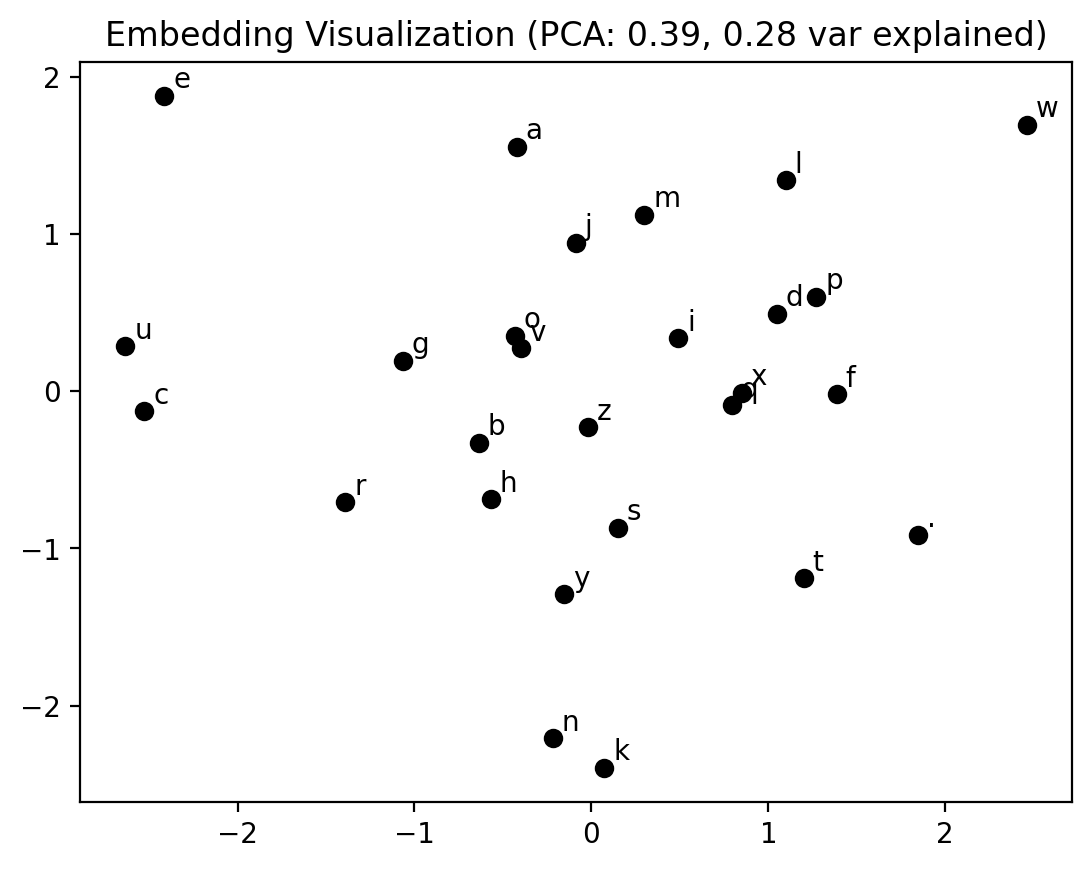

In [17]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # Get embedding weights and handle different dimensions
    weights = emb.weight.detach().cpu().numpy()
    
    if weights.shape[1] == 2:
        # For 2D embeddings, plot directly
        for i in range(len(itos)):
            x, y = weights[i]
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
    elif weights.shape[1] > 2:
        # For higher dimensions, use PCA to reduce to 2D
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        weights_2d = pca.fit_transform(weights)
        
        for i in range(len(itos)):
            x, y = weights_2d[i]
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
            
        # Add explained variance info to title
        explained_var = pca.explained_variance_ratio_
        ax.set_title(f'Embedding Visualization (PCA: {explained_var[0]:.2f}, {explained_var[1]:.2f} var explained)')
    else:
        # For 1D embeddings, create a scatter plot with y=0
        for i in range(len(itos)):
            x = weights[i, 0]
            y = 0
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
        ax.set_ylabel('(1D embedding)')
    
    return ax

plot_emb(emb, itos)

In [18]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x


In [19]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def print_model_summary(model):
    print("Model Summary:")
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            params = sum(p.numel() for p in module.parameters())
            print(f"{name:<20} {params:,} parameters")
    print(f"\nTotal trainable parameters: {count_params(model):,}\n")


def train_model(model, X, Y, epochs=500, batch_size=1024, lr=1e-3, wd=1e-2, print_every=100):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    losses, times = [], []
    for epoch in range(epochs):
        start = time.time()
        total_loss, n_batches = 0, 0

        for i in range(0, X.shape[0], batch_size):
            x_batch = X[i:i+batch_size]
            y_batch = Y[i:i+batch_size]

            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            n_batches += 1

        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        times.append(time.time() - start)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f} | Time: {times[-1]:.2f}s")

    return losses, times


In [20]:
g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        context = [0] * block_size
        name = ''
        for i in range(max_len):
            x = torch.tensor(context).view(1, -1).to(device)
            y_pred = model(x)
            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
            ch = itos[ix]
            if ch == '.':
                break
            name += ch
            context = context[1:] + [ix]
    # Set model back to training mode
    model.train()
    return name

Model Summary:
_orig_mod.emb        108 parameters
_orig_mod.lin1       1,344 parameters
_orig_mod.lin2       1,755 parameters

Total trainable parameters: 3,207

Generated names before training:
 1. rhxvgxhjkt
 2. wgtoguopww
 3. 
 4. kolplkxsjc
 5. pkyluclpxb
 6. ylgegxrpyq
 7. trfgmboinz
 8. klhlqyxbdi
 9. kjumruvdgr
10. wwyugcmcfn

Embedding visualization before training:


<Axes: title={'center': 'Embedding Visualization (PCA: 0.43, 0.24 var explained)'}>

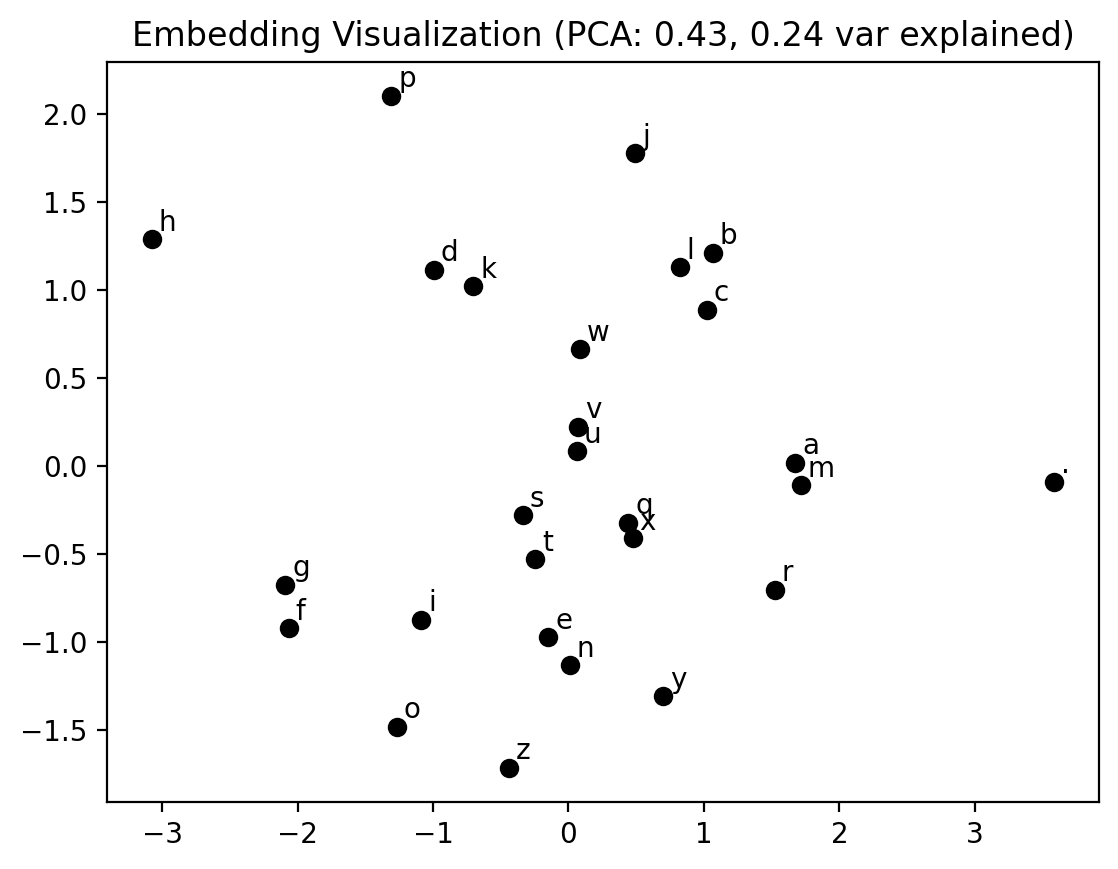

In [21]:
# Create enhanced model and show before training

model = NextChar(block_size, len(stoi), emb_dim, hidden_size=64).to(device)
model = torch.compile(model)

## Model parameters:
print_model_summary(model)

# Generate some names before training
print("Generated names before training:")
print("="*50)
for i in range(10):
    name = generate_name(model, itos, stoi, block_size)
    print(f"{i+1:2d}. {name}")

# Visualize embedding before training
print("\nEmbedding visualization before training:")
plot_emb(model.emb, itos)



In [22]:
losses, times = train_model(model, X, Y, epochs=1200, batch_size=4096, lr=0.001, wd=0.01, print_every=200)  

Epoch    0 | Loss: 3.3309 | Time: 0.15s
Epoch  200 | Loss: 2.0473 | Time: 0.02s
Epoch  400 | Loss: 2.0092 | Time: 0.02s
Epoch  600 | Loss: 1.9948 | Time: 0.02s
Epoch  800 | Loss: 1.9849 | Time: 0.02s
Epoch 1000 | Loss: 1.9785 | Time: 0.02s



Embedding visualization after training:


<Axes: title={'center': 'Embedding Visualization (PCA: 0.34, 0.30 var explained)'}>

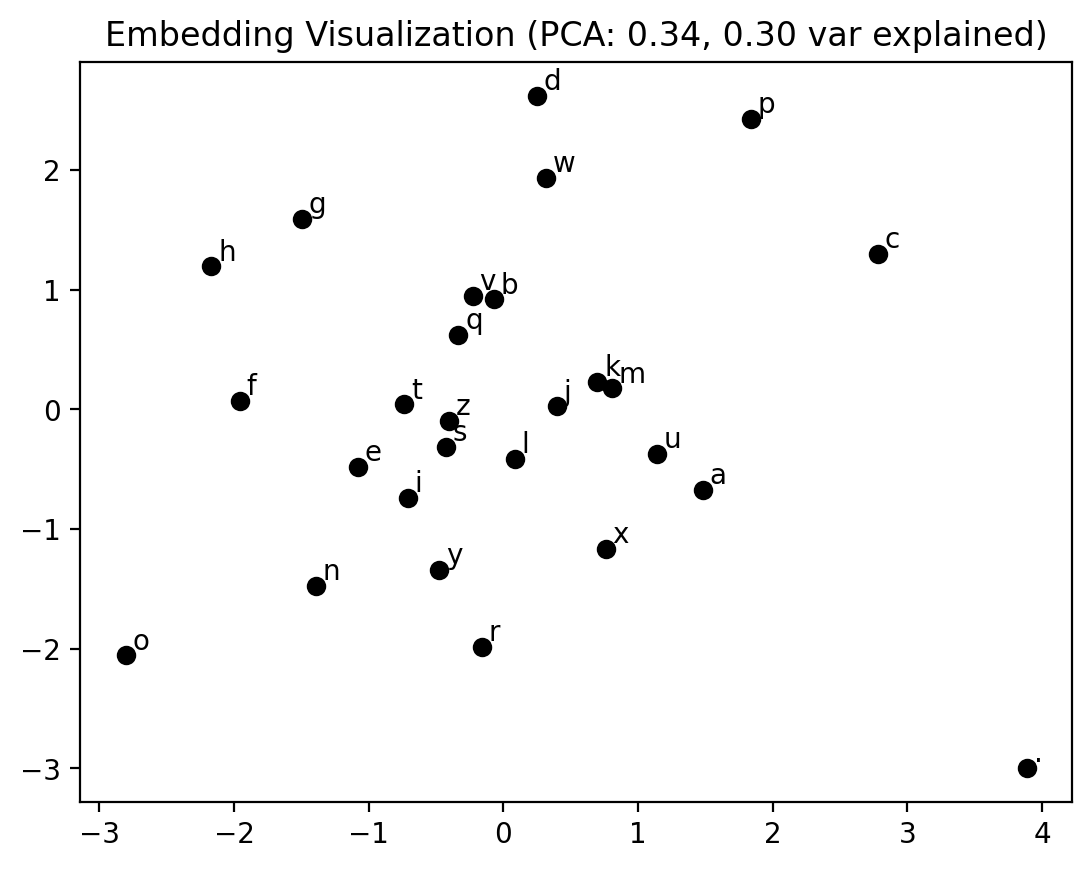

In [23]:
# Visualize the embedding post training
print("\nEmbedding visualization after training:")

plot_emb(model.emb, itos)

In [24]:
# Generate some names after training
print("Generated names after training:")
print("="*50)
for i in range(10):
    name = generate_name(model, itos, stoi, block_size)
    print(f"{i+1:2d}. {name}")  


Generated names after training:
 1. ruke
 2. yatnit
 3. kamannadar
 4. rujia
 5. bahid
 6. sadit
 7. moojosheka
 8. dasmi
 9. btere
10. virontim


In [25]:
class NextCharResidual(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.fc_in = nn.Linear(block_size * emb_dim, hidden_size)
        
        # Residual MLP block
        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
        )
        
        self.bn_out = nn.BatchNorm1d(hidden_size)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_in(x)
        residual = x
        x = self.block(x) + residual  # Residual connection
        x = torch.relu(self.bn_out(x))
        x = self.fc_out(x)
        return x


In [26]:
model = NextCharResidual(block_size, len(stoi), emb_dim, hidden_size=128, dropout=0.2).to(device)


In [27]:
print_model_summary(model)

print("="*60)
print("Before Training Samples:")
print("="*60)
model.eval()
with torch.no_grad():
    for i in range(10):
        name = generate_name(model, itos, stoi, block_size)
        print(f"{i+1:2d}. {name}")

Model Summary:
emb                  108 parameters
fc_in                2,688 parameters
block.0              16,512 parameters
block.1              256 parameters
block.2              0 parameters
block.3              0 parameters
block.4              16,512 parameters
bn_out               256 parameters
fc_out               3,483 parameters

Total trainable parameters: 39,815

Before Training Samples:
 1. aahjntjrft
 2. mwtjftjxls
 3. nngytoaajl
 4. qbrkgnpsob
 5. qkcythjacj
 6. rndyqkztsl
 7. qkrbgzvoee
 8. yhmkmswkru
 9. a
10. rvseqthjmp


In [28]:
model.train()
losses, times = train_model(model, X, Y, epochs=1000, batch_size=2048, print_every=200)
print(f"Final loss: {losses[-1]:.4f}")

Epoch    0 | Loss: 2.8199 | Time: 0.08s
Epoch  200 | Loss: 1.8501 | Time: 0.08s
Epoch  400 | Loss: 1.7812 | Time: 0.10s
Epoch  600 | Loss: 1.7455 | Time: 0.08s
Epoch  800 | Loss: 1.7242 | Time: 0.08s
Final loss: 1.7086



Embedding visualization after training:


<Axes: title={'center': 'Embedding Visualization (PCA: 0.32, 0.26 var explained)'}>

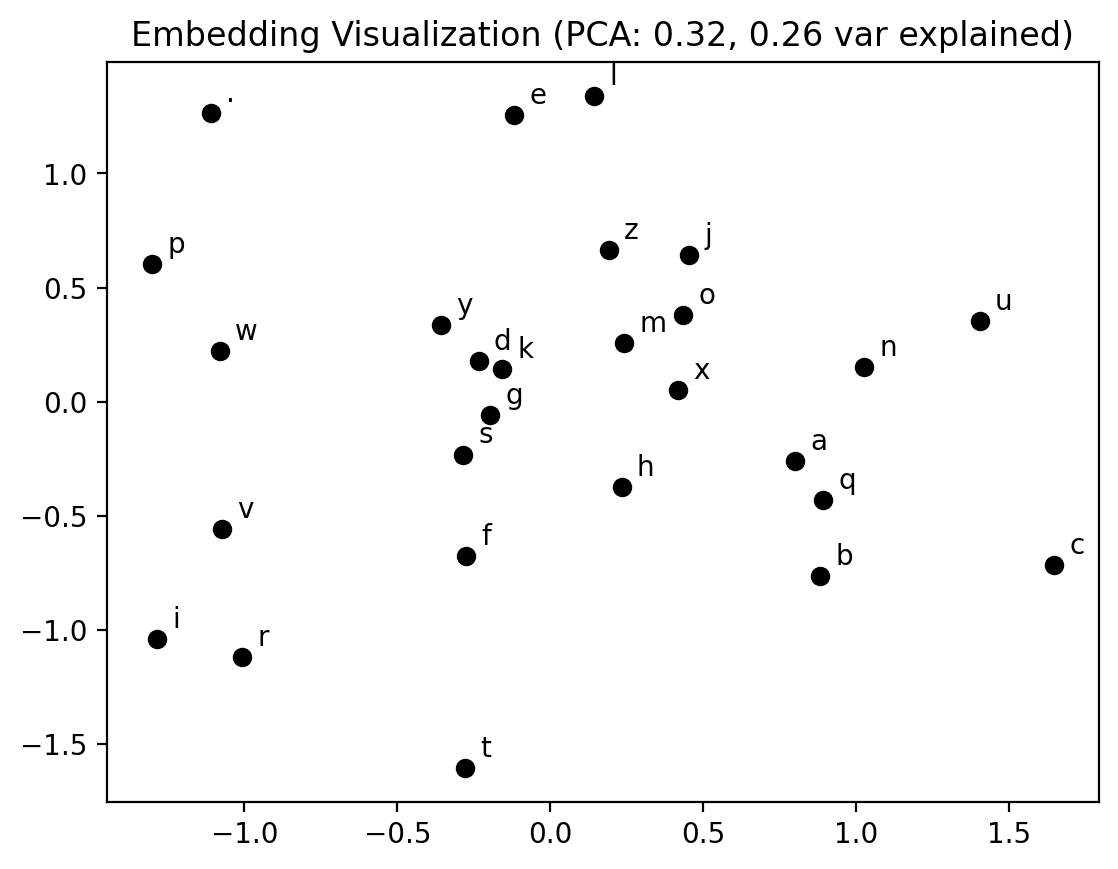

In [29]:
print("\nEmbedding visualization after training:")
plot_emb(model.emb, itos)

In [30]:
# Generate some names after training
print("Generated names after training:")
print("="*50)
for i in range(10):
    name = generate_name(model, itos, stoi, block_size)
    print(f"{i+1:2d}. {name}")



Generated names after training:
 1. munnta
 2. ramkanit
 3. bhuram
 4. kifala
 5. narona
 6. sanj
 7. seeta
 8. sheilesh
 9. sukma
10. farhba


Tuning knobs

1. Embedding size
2. MLP 
3. Context length